In [37]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# --- Configurações ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Rodando no dispositivo: {device}")

block_size = 64 # block_size: Passe de 32 para 64 ou 128. (Ajuda ele a lembrar o começo da frase).
batch_size = 16
max_iters = 5000 # max_iters: Passe de 2000 para 5000 ou 10000. (É o que mais vai fazer diferença).
learning_rate = 1e-3
eval_iters = 200
n_embd = 64 # n_embd: Tente 128 ou 192.
n_layer = 4
n_head = 4 # n_head: Se aumentar o n_embd, aumente as cabeças (ex: 6 cabeças para 192, pois 192/6 = 32).
dropout = 0.2  # dropout: Se o texto ficar repetitivo demais, aumente para 0.2. Se ficar aleatório demais, baixe para 0.1.

# Meta: Tente fazer a val loss (perda de validação) cair para abaixo de 1.7.
# Loss > 2.0: Balbucios.
# Loss ~ 1.5: Frases curtas fazem sentido.
# Loss < 1.0: Texto quase perfeito.

Rodando no dispositivo: cpu


In [38]:
with open('wizard_of_oz.txt', 'r', encoding='utf-8') as f:
    text = f.read()
    
chars = sorted(list(set(text)))

vocab_size = len(chars)

In [39]:
string_to_int = { ch:i for i,ch in enumerate(chars) }
int_to_string = {i:ch for i,ch in enumerate(chars) }
encode = lambda s: [string_to_int[c] for c in s]
decode = lambda l: ''.join([int_to_string[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)

In [40]:
n = int(0.8*len(data))
train_data = data[:n]
val_data = data[n:]

In [41]:
# --- Funções Auxiliares ---
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [42]:
#Head é o mecanismo de "comunicação". 
# É onde os tokens olham uns para os outros e decidem quem é relevante para quem. 
# O tril (máscara triangular) garante que, ao tentar prever a 5ª palavra, o modelo só possa olhar para as palavras 1, 2, 3 e 4, e nunca para a 6ª (futuro).
class Head(nn.Module):
    """ uma cabeça de auto-atenção (self-attention) """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        # O buffer 'tril' é a máscara triangular inferior para garantir que 
        # o modelo não "olhe para o futuro" (causal masking)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input de tamanho (batch, time-step, channels) = (B,T,C)
        B, T, C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        
        # computa os scores de atenção ("afinidade")
        # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = q @ k.transpose(-2, -1) * C**-0.5 
        
        # Aplica a máscara: tudo que é 0 vira -infinito (para o softmax ignorar)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) 
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        
        # realiza a agregação ponderada dos valores
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

#MultiHeadAttention é como ter várias "opiniões" diferentes. 
# Uma cabeça pode focar na gramática, outra em nomes próprios, outra na relação sujeito-verbo. 
# O modelo aprende essas especializações sozinho.
class MultiHeadAttention(nn.Module):
    """ múltiplas cabeças de atenção em paralelo """

    def __init__(self, num_heads, head_size):
        super().__init__()
        # Cria uma lista de módulos Head independentes
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        # Projeção final para misturar os resultados das cabeças
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Concatena os resultados na dimensão dos canais (última dimensão)
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

#FeedForward é o mecanismo de "computação" ou "reflexão". 
# Depois que os tokens trocam informações na Atenção, eles "pensam" sobre essa informação individualmente nesta camada densa antes de passar para o próximo bloco.
class FeedForward(nn.Module):
    """ uma camada linear simples seguida de não-linearidade """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            # A camada interna geralmente expande por um fator de 4 (padrão do paper original)
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd), # Projeta de volta para o tamanho original
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
    def forward(self, x):
        y = self.sa(x)
        x = self.ln1(x + y)
        y = self.ffwd(x)
        x = self.ln2(x + y)
        return x
        
class GPTLanguageModel(nn.Module):
    def __init__(self): # Removido vocab_size do argumento pois já é global, ou passe explicitamente
        super().__init__()
        # Correção da dimensão de saída para n_embd
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        
        # Correção do nome da função
        self.apply(self._init_weights)

    def _init_weights(self, module): # Correção dos underscores
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, index, targets=None):
        B, T = index.shape
        
        # Correção: usar 'index' e não 'idx'
        tok_emb = self.token_embedding_table(index) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            # Correção: Cortar o contexto para não estourar o block_size
            idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]

            # Pega as previsões
            logits, _ = self(idx_cond)

            # Foca apenas no último passo de tempo (o último token)
            logits = logits[:, -1, :] # vira (B, C)

            # Aplica softmax para obter probabilidades
            probs = F.softmax(logits, dim=-1) # (B, C)

            # Amostra (sorteia) o próximo token baseado nas probabilidades
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)

            # Adiciona o novo token à sequência (concatena)
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [43]:
# Instanciar o Modelo
model = GPTLanguageModel()
m = model.to(device)
print(f"Modelo criado com {sum(p.numel() for p in m.parameters())/1e6:.2f} M parâmetros")
# Pra fim comparativo o GPT 1 da OPENAI teve em 2018 117 MILHÕES de parametros

Modelo criado com 0.21 M parâmetros


In [44]:
# Otimizador
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [45]:
# Loop de Treinamento
print("Iniciando treinamento...")
for iter in range(max_iters):
    
    if iter % eval_iters == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    xb, yb = get_batch('train')

    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print("Treinamento finalizado.")

Iniciando treinamento...


step 0: train loss 4.4179, val loss 4.4188
step 200: train loss 2.4629, val loss 2.5119
step 400: train loss 2.3146, val loss 2.3748
step 600: train loss 2.1598, val loss 2.2496
step 800: train loss 2.0272, val loss 2.1301
step 1000: train loss 1.9345, val loss 2.0399
step 1200: train loss 1.8641, val loss 1.9742
step 1400: train loss 1.8072, val loss 1.9346
step 1600: train loss 1.7559, val loss 1.8875
step 1800: train loss 1.7240, val loss 1.8673
step 2000: train loss 1.6983, val loss 1.8323
step 2200: train loss 1.6686, val loss 1.8078
step 2400: train loss 1.6470, val loss 1.7923
step 2600: train loss 1.6197, val loss 1.7744
step 2800: train loss 1.6100, val loss 1.7721
step 3000: train loss 1.5972, val loss 1.7654
step 3200: train loss 1.5825, val loss 1.7380
step 3400: train loss 1.5746, val loss 1.7267
step 3600: train loss 1.5574, val loss 1.7483
step 3800: train loss 1.5422, val loss 1.7119
step 4000: train loss 1.5316, val loss 1.7011
step 4200: train loss 1.5297, val loss 1.

In [46]:
# Geração de Texto
print("\n" + "="*30)
print("GERANDO TEXTO COM O MODELO TREINADO")
print("="*30 + "\n")

model.eval()
context = torch.zeros((1, 1), dtype=torch.long, device=device)
generated_ids = model.generate(context, max_new_tokens=500)
print(decode(generated_ids[0].tolist()))


GERANDO TEXTO COM O MODELO TREINADO


"Ink ound the Land Land of Oz Jim im, it let me?" enquered the Wizard, which the enquer, were ben the place.


The Mangabbion her of it
twhings the some discless.

Belly you forgh a roat."

"ourgh the I'lllson in the Affter the be was with it one chees one
to becaselving the jurners, when ho surep feelly was eling to reshord had noow the imple and sater, who
nothed here about of the right."

"Them ord noin!" he here tome hours all hoursered wish gruettion to the enter
from friends. Dorothy, into


Iniciando treinamento com registro de histórico...
step 0: train loss 1.4901, val loss 1.6892
step 200: train loss 1.4821, val loss 1.6715
step 400: train loss 1.4793, val loss 1.6611
step 600: train loss 1.4789, val loss 1.6588
step 800: train loss 1.4677, val loss 1.6493
step 1000: train loss 1.4612, val loss 1.6573
step 1200: train loss 1.4551, val loss 1.6378
step 1400: train loss 1.4542, val loss 1.6444
step 1600: train loss 1.4402, val loss 1.6461
step 1800: train loss 1.4376, val loss 1.6371
step 2000: train loss 1.4355, val loss 1.6412
step 2200: train loss 1.4371, val loss 1.6227
step 2400: train loss 1.4275, val loss 1.6260
step 2600: train loss 1.4207, val loss 1.6147
step 2800: train loss 1.4014, val loss 1.6211
step 3000: train loss 1.4084, val loss 1.6207
step 3200: train loss 1.4047, val loss 1.6218
step 3400: train loss 1.4057, val loss 1.6151
step 3600: train loss 1.3999, val loss 1.6057
step 3800: train loss 1.3998, val loss 1.6098
step 4000: train loss 1.4033, val lo

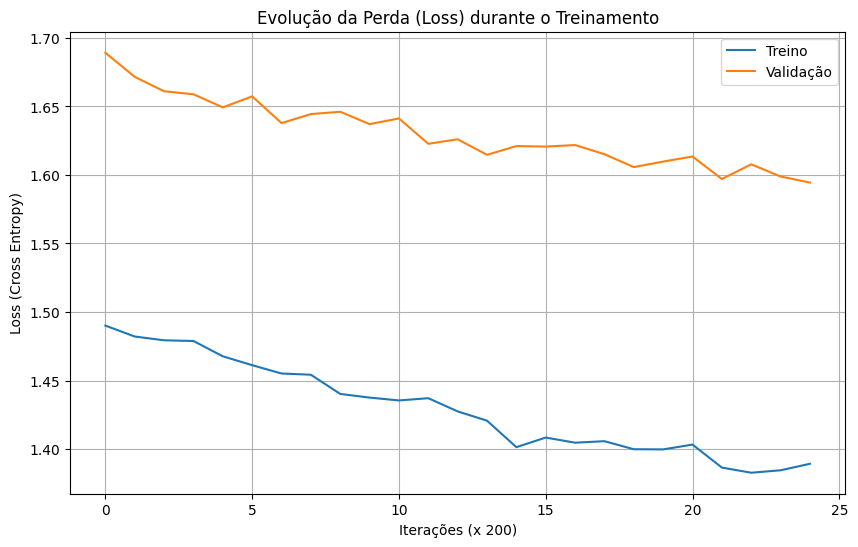

In [47]:
import matplotlib.pyplot as plt

loss_history_train = []
loss_history_val = []

print("Iniciando treinamento com registro de histórico...")
for iter in range(max_iters):
    
    if iter % eval_iters == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        # Guardando os valores para o gráfico
        loss_history_train.append(losses['train'])
        loss_history_val.append(losses['val'])

    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# --- Plotando o Gráfico ---
plt.figure(figsize=(10, 6))
plt.plot(loss_history_train, label='Treino')
plt.plot(loss_history_val, label='Validação')
plt.title('Evolução da Perda (Loss) durante o Treinamento')
plt.xlabel('Iterações (x 200)') # Ajustar conforme o valor de eval_iters
plt.ylabel('Loss (Cross Entropy)')
plt.legend()
plt.grid(True)
plt.savefig('grafico_loss_tcc.png') # Salva a imagem na pasta
print("Gráfico salvo como grafico_loss_tcc.png")